# IDS Integrated Data Asset (IDA) Linkage demo

This script is broadly intended to demonstrate how easily RDMF indexed IDAs can be linked and thus prepared for analysts to use.

In [203]:
# import needed packages (not many!)
from google.cloud import bigquery
import pandas as pd

In [204]:
# initiate client for bigquery
client = bigquery.Client(location="europe-west2")

## Joining std and georef files
First, we need to link together the `std` and `georef` versions of the required assets, so that we have all of the data's attributes, along with it's geographic information that will link back to the address/geography indexes. These each have `guid` columns this can be done with.

First, let's do this for the Energy Performance Certificates data, which will give us insights into housing energy efficiency:

Next, let's do the same for the Land Registry Price Paid (LRPP) data, which will give us house sale price information:

In [47]:
# joining georef and std LRPP tables
query = ("""

SELECT
  *
FROM
  `ingest_ida_land_registry_price_paid.prices_paid_georef` t1
JOIN
  `ingest_ida_land_registry_price_paid.prices_paid_std` t2
ON
  t1.id = t2.guid

""")
table_ref = 'ons-ids-analysis-prod.demo_wip_notebook.lrpp_linked'

job_config = bigquery.QueryJobConfig(
    destination= table_ref
)

query_job = client.query(
    query,
    location="europe-west2",
    job_config=job_config
)


query_job.result()

## Linking the EPC, LRPP and OSPOS data
Finally, and this is the bit where the Integrated Data Asset version of these datasets comes in handy, we can link all of these sources together on their `address_entry_id` variables. This is the lookup to the RDMF, specifically the address index, and is a unique identifier in this case.

In [103]:
# joining OSPOS and (newly joined) LRPP tables
query = ("""

SELECT
  geography_entry_id_lsoa_code,
  geography_entry_id_oa_code,
  geography_entry_id_lad_code,
  geography_entry_id_msoa_code,
  geography_entry_id_country_code,
  geography_entry_id_region_code,
  lsoa_code_hashed,
  oa_code_hashed,
  lad_code_hashed,
  msoa_code_hashed,
  country_code_hashed,
  region_code_hashed,
  class,
  voa_ct_record,
  ruc_code,
  ruc,
  ur2fold,
  ur3fold,
  ur6fold,
  ur8fold,
  building_flat_count,
  private_outdoor_space,
  private_outdoor_space_area,
  t1.address_entry_id_uprn,
  t2.address_entry_id_uprn AS t2_address_entry_id_uprn,
  t2.id,
  apiversion,
  confidencescore,
  epoch,
  underlyingscore,
  t2.geography_entry_id_postcode,
  t2.postcode_hashed,
  t2.guid,
  t2.transaction_uid,
  price,
  date_of_transfer,
  t2.property_type,
  old_new,
  duration,
  locality,
  ppd_category_type,
  derived_year
FROM
  `ons-ids-data-prod.ingest_ida_ordnance_survey_private_outside_space.april_gb_private_outdoor_space_std` AS t1
JOIN
  `ons-ids-analysis-prod.demo_wip_notebook.lrpp_linked` AS t2
ON
  t1.address_entry_id_uprn = t2.address_entry_id_uprn
  
""")

table_ref = 'ons-ids-analysis-prod.demo_wip_notebook.ospos_lrpp_linked'

job_config = bigquery.QueryJobConfig(
    destination= table_ref
)

job_config.write_disposition = "WRITE_TRUNCATE"

query_job = client.query(
    query,
    location="europe-west2",
    job_config=job_config
)

query_job.result()

In [160]:
# create linked OSPOS_LRPP to GI table
query = ("""
SELECT 

 geography_entry_id_region_code
 
FROM 
 `ons-ids-analysis-prod.demo_wip_notebook.ospos_lrpp_linked` AS t1
 
""")

query_job = client.query(
    query,
    location="europe-west2",
)  # API request - starts the query

ospos_lrpp = query_job.to_dataframe()

In [183]:
# create linked OSPOS_LRPP to GI table
query = ("""
SELECT 

 *
 
FROM 
 `ons-ids-analysis-prod.demo_wip_notebook.ospos_lrpp_linked`
 
WHERE 1 = 0
""")

query_job = client.query(
    query,
    location="europe-west2",
)  # API request - starts the query

linked_cols = query_job.to_dataframe()

In [190]:
linked_cols = linked_cols.columns.tolist()

In [164]:
len(ospos_lrpp[ospos_lrpp.geography_entry_id_region_code.isnull()==False])

24612812

## Non-matches and bias

In [299]:
# create matched dataframe - linked OSPOS_LRPP to GI table
query = ("""
SELECT 

 address_entry_id_uprn,
 t1.geography_entry_id_region_code AS t1_geography_entry_id_region_code,
 t2.region_name
 
FROM 
 `ons-ids-analysis-prod.demo_wip_notebook.ospos_lrpp_linked` AS t1
 
JOIN
  `ons-ids-analysis-prod.demo_wip_notebook.geography_index_lookup` AS t2
ON
  t1.geography_entry_id_region_code = t2.geography_entry_id_region_code

""")

query_job = client.query(
    query,
    location="europe-west2",
)  # API request - starts the query

matches = query_job.to_dataframe()

In [300]:
matches.region_name.value_counts()

South East                  4487211
London                      3213019
North West                  3124714
East of England             3009032
South West                  2811756
Yorkshire and The Humber    2339805
West Midlands               2320427
East Midlands               2188952
North East                  1117896
Name: region_name, dtype: int64

In [302]:
# create non-matches dataframe
query = ("""
SELECT 

 address_entry_id_uprn,
 geography_entry_id_region_code,
FROM
  `ons-ids-data-prod.ingest_ida_ordnance_survey_private_outside_space.april_gb_private_outdoor_space_std`
WHERE address_entry_id_uprn is NULL
""")

query_job = client.query(
    query,
    location="europe-west2",
)  # API request - starts the query

non_matches_ospos = query_job.to_dataframe()

In [316]:
# read in OSPOS for region lookup to ospos non-links
query = ("""
SELECT 

 address_entry_id_uprn,
 geography_entry_id_region_code
FROM
  `ons-ids-data-prod.ingest_ida_ordnance_survey_private_outside_space.april_gb_private_outdoor_space_std`
""")

query_job = client.query(
    query,
    location="europe-west2",
)  # API request - starts the query

ospos = query_job.to_dataframe()

In [307]:
# create non-matches dataframe
query = ("""
SELECT 

 address_entry_id_uprn
FROM
  `ons-ids-analysis-prod.demo_wip_notebook.lrpp_linked`
WHERE address_entry_id_uprn is NULL
""")

query_job = client.query(
    query,
    location="europe-west2",
)  # API request - starts the query

non_matches_lrpp = query_job.to_dataframe()

In [310]:
len(matches)

24612812

In [311]:
ospos_lrpp_linked

,address_entry_id_uprn,t2_address_entry_id_uprn
0,100000012966370,100000012966370
1,100000032249077,100000032249077
2,100000032274111,100000032274111
3,100000013294831,100000013294831
4,100000032257715,100000032257715
...,...,...
25836155,100000020977548,100000020977548
25836156,100000020158094,100000020158094
25836157,100000020189069,100000020189069
25836158,100000020194275,100000020194275


In [314]:
ospos_non_links.columns

Index(['address_entry_id_uprn', 't2_address_entry_id_uprn', '_merge'], dtype='object')

In [320]:
len(ospos[ospos['geography_entry_id_region_code'].isnull()==True])

4094004

In [321]:
# read in geography index lookup
query = ("""
SELECT 

 *
FROM
  `ons-ids-analysis-prod.demo_wip_notebook.geography_index_lookup`
""")

query_job = client.query(
    query,
    location="europe-west2",
)  # API request - starts the query

gi = query_job.to_dataframe()

In [323]:
# join to ospos
ospos = pd.merge(ospos, gi, on = 'geography_entry_id_region_code', how = 'left')

In [333]:
links = ospos.region_name.value_counts().to_frame()

In [334]:
links.columns = ['count']
links.index.names = ['region']

In [335]:
non_links = ospos[ospos['address_entry_id_uprn'].isnull()==True]['region_name'].value_counts().to_frame()

In [336]:
non_links.columns = ['missing_count']
non_links.index.names = ['region']

In [338]:
df = pd.merge(links, non_links, on = 'region', how = 'inner')

In [341]:
df['linked_proportion'] = df['count']/df['count'].sum()*100

In [343]:
df['non-linked_proportion'] = df['missing_count']/df['missing_count'].sum()*100

In [352]:
df

,count,missing_count,linked_proportion,non-linked_proportion
region,,,,
South East,3975289,199,16.078,6.576
London,3705559,187,14.987,6.180
North West,3352136,857,13.558,28.321
East of England,2723723,583,11.016,19.266
South West,2604713,367,10.535,12.128
West Midlands,2538382,250,10.266,8.262
Yorkshire and The Humber,2453391,322,9.923,10.641
East Midlands,2123235,257,8.587,8.493
North East,1248477,4,5.049,0.132


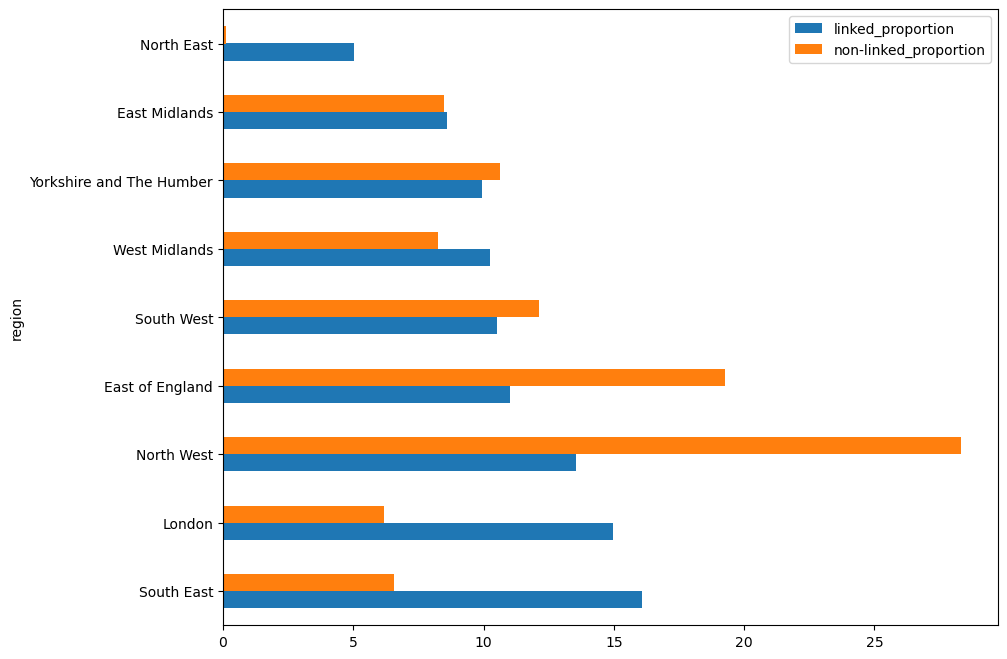

In [354]:
ax = df[['linked_proportion','non-linked_proportion']].plot.barh(figsize=(10,8))

For cases where records did not match to an RDMF index, for example the address index, their `address_entry_id` will be null. This allows identification of the non-matching records

In [355]:
unmatched  = len(df[df.address_entry_id_uprn.isnull() == True])
matched  = len(df[df.address_entry_id_uprn.isnull() == False])

print("the match rate is:", ((matched-unmatched)/matched)*100)

AttributeError: 'DataFrame' object has no attribute 'address_entry_id_uprn'

The analysts can then easily explore the characteristics of the non-linking data. For instance, exploring the trends in matches vs non-matches by region:

In [10]:
# read in geography index lookup, join on geography_entry_region_code

# hashed values - can aggregate on these hashed values to explore bias (i.e. same hashed uprn for same hh)

# match rate by region

26886828

In [ ]:
# exploring LRPP join
query = ("""
SELECT 
COUNT(*) as numRecords

FROM `ingest_ida_land_registry_price_paid.prices_paid_georef` t1
JOIN `ingest_ida_land_registry_price_paid.prices_paid_std` t2

ON t1.id = t2.guid;
""")

query_job = client.query(
    query,
    location="europe-west2",
)  # API request - starts the query

df  = query_job.to_dataframe()

In [30]:
# all 26889532 records join
df

,numRecords
0,26889532


In [16]:
# exploring LRPP columns, querying where a false condition is true to just return column names
query = ("""
SELECT * 

FROM `ingest_ida_land_registry_price_paid.prices_paid_std`

WHERE 1 = 0
""")

query_job = client.query(
    query,
    location="europe-west2",
)  # API request - starts the query

df  = query_job.to_dataframe()


In [17]:
df.columns.tolist()

['geography_entry_id_postcode',
 'postcode_hashed',
 'guid',
 'transaction_uid',
 'price',
 'date_of_transfer',
 'property_type',
 'old_new',
 'duration',
 'locality',
 'ppd_category_type',
 'derived_year']